# Reservoirs

This notebook compares observed and simulated reservoir data at several reservoirs in the Nira river sub-basin of the Upper Bhima basin.

Currently, the following data are being used:
 - Reservoir levels
 - Discharge
 - Inflow
 
The observed data for which we compare CWatM simulated reservoir levels are kindly offered on behalf of the National Hydrological Project, India.

In [1]:
from netCDF4 import Dataset, num2date
import plotly.graph_objects as go
import numpy as np
import datetime
from PIL import Image
import os

## File locations

In [2]:
fuse_folder_local = 'C:/FUSE'
fuse_folder_github = 'C:/GitHub/FUSE'
cwatm_folder_local = fuse_folder_local + '/CWATM'
output_folder = cwatm_folder_local + '/Output'

photo_folder = fuse_folder_github + '/Images'
measuredData_folder = fuse_folder_local + '/Output' #_2020_Feb_26' #Data_forNotebooks/Reservoir_Historical/Reservoir level_inflow_floodcontrol'

Dam_names = ['Vir', 'Gunjvane', 'NiraDeoghar', 'Bhatghar']
Reservoirs_Sarati = Dam_names

Inds =  [(164,111), (143,55), (168,66), (159,84)]

Vars = [['lakeResStorage', 'Lake Level', 'Reservoir Volume', 'Volume (MCM)', 1000000.],
        ['lakeResOutflowDis', 'Spilling', 'Reservoir Outflow', 'Outflow (m3/s)', 1.], 
        ['lakeResInflowDis', 'positive', 'Reservoir Inflow', 'Inflow (m3/s)', 1.]]
        #['act_bigLakeResAbst_alloc', 'Irrigation Use', 'Irrigation Use', 'Volume (MCM)', 1000000.]]

        #['lakeResStorage_alloc', '', 'Total water in segment', 'Volume (MCM)', 1000000.]] 

SIMULATED_nc = []

for var in Vars:
    reservoir_nc_filename = output_folder +'/'+ var[0] + '_daily.nc'
    SIMULATED_nc.append(Dataset(reservoir_nc_filename, 'r'))

## Introduction

Here, we present the locations and names of the reservoirs of interest.

Ujjani reservoir is only shown for spatial context.

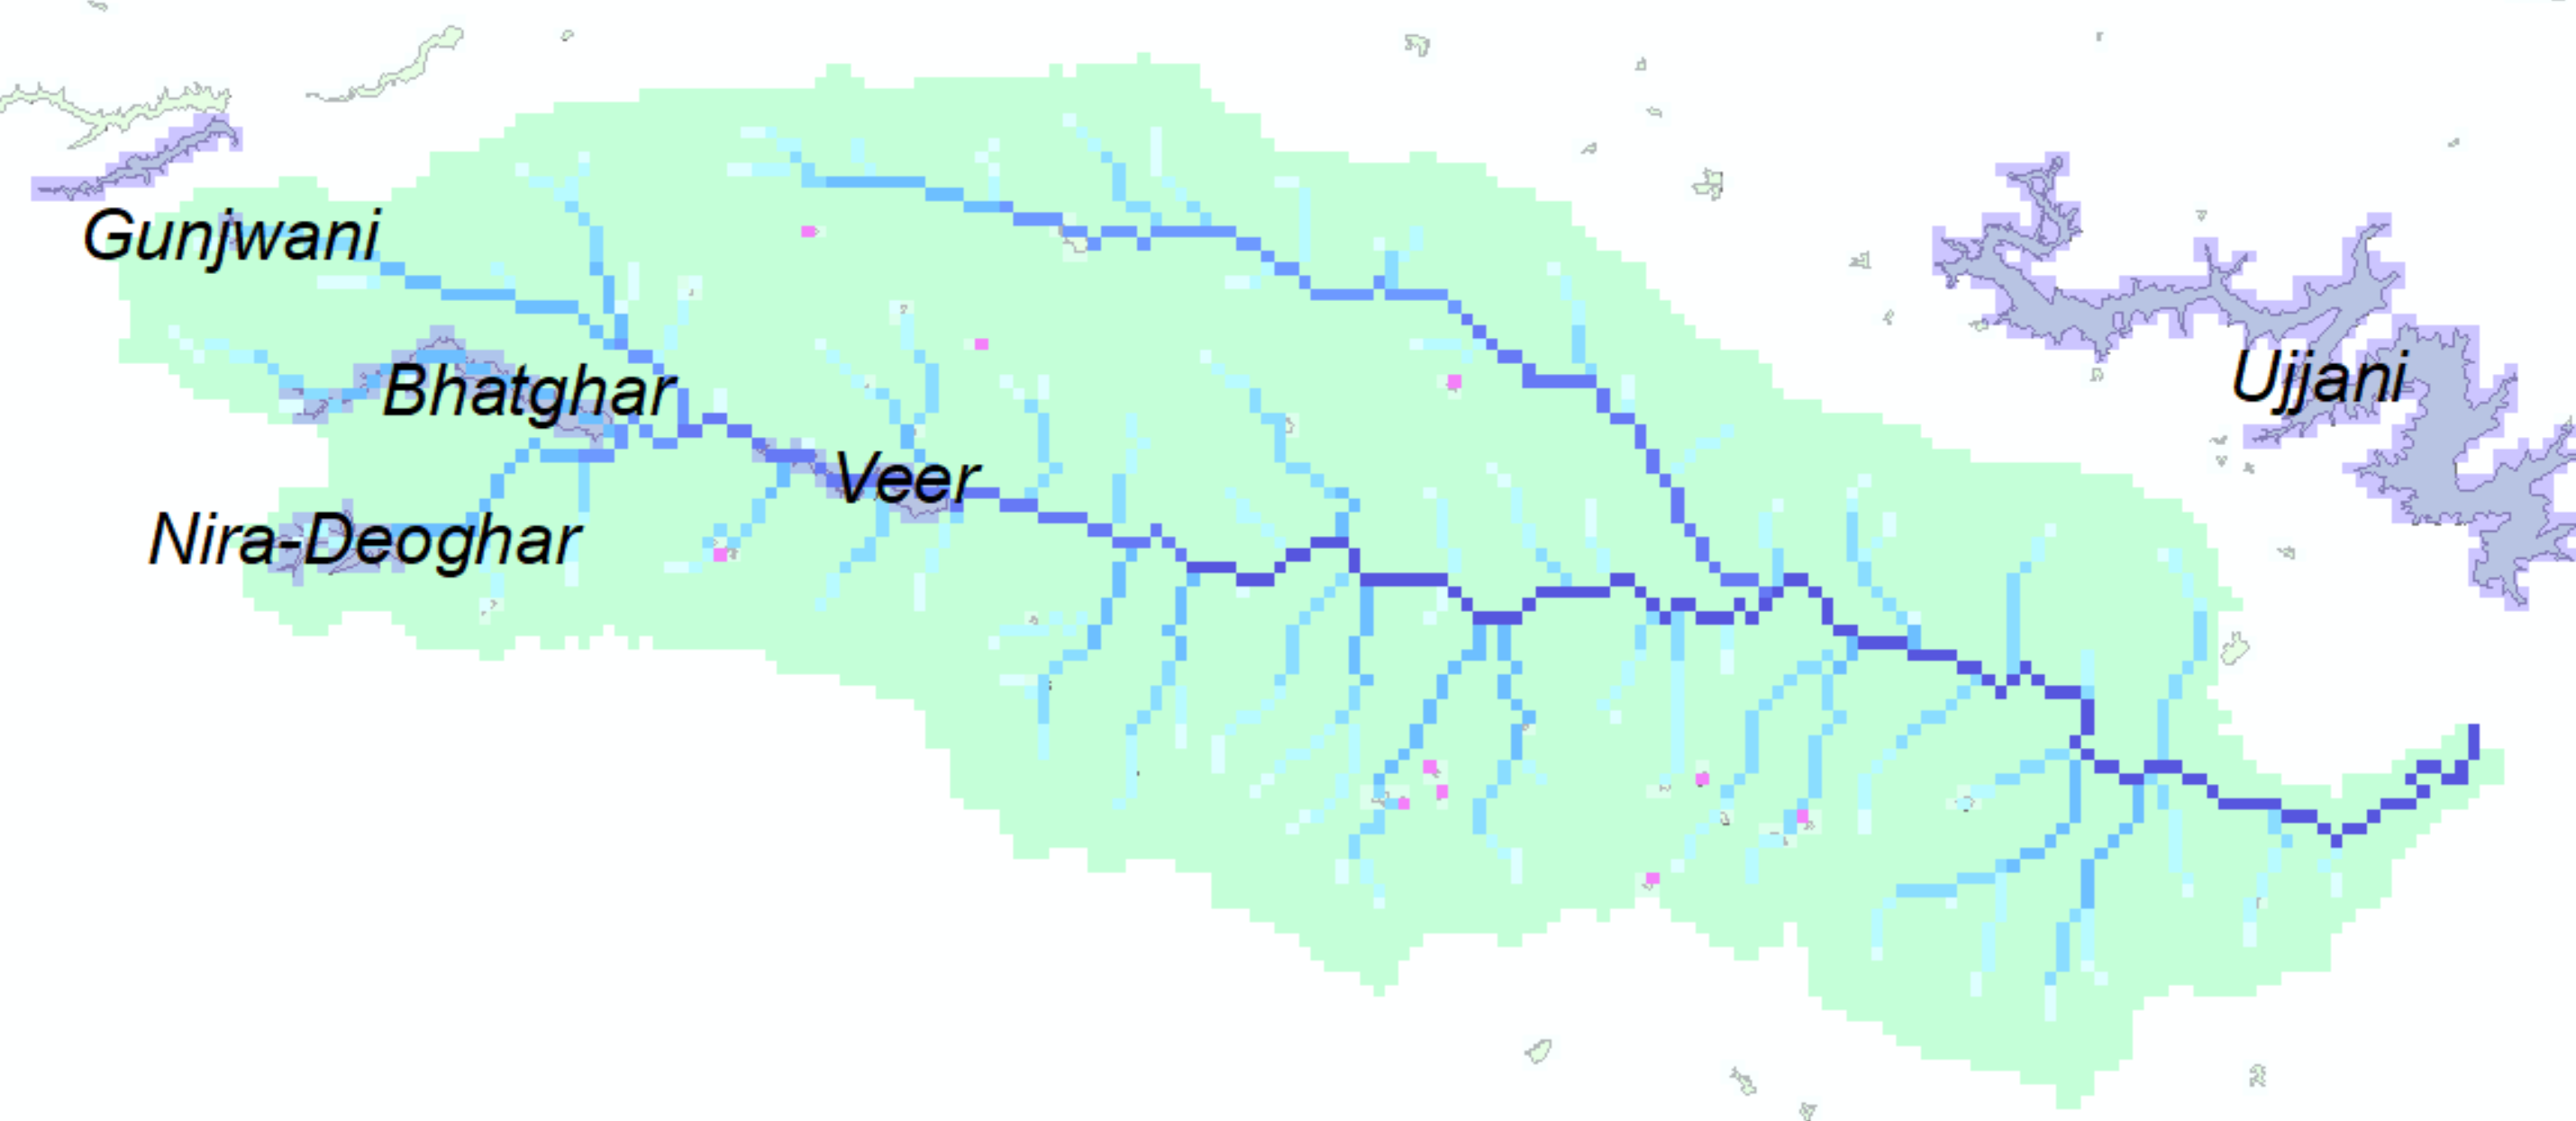

In [3]:
img = Image.open(photo_folder + '/reservoirs_onSarati.png')
img

In [4]:
Dates_simulation = num2date(SIMULATED_nc[0].variables['time'][:], units=SIMULATED_nc[0].variables['time'].units)

OverflowError: Python int too large to convert to C int

The below block of code can be activated to list the locations of the reservoir outlet points .

In [ ]:
Storage = SIMULATED_nc[0].variables['lakeResStorage'][1,:,:]
reservoirs = []

for i in range(SIMULATED_nc[0].variables['lat'].shape[0]):
    for j in range (SIMULATED_nc[0].variables['lon'].shape[0]):
        if Storage[i,j] > 0:
            
            reservoirs.append([Storage[i,j], i, j])
            
print(reservoirs)

In [ ]:
DAMS = []

for i in range(len(Vars)): 
    Dams = []
    for inds in Inds:
        Dams.append(SIMULATED_nc[i].variables[Vars[i][0]][:,inds[0], inds[1]]/Vars[i][4])
    DAMS.append(Dams)
    

## CWatM Simulations: 
 - Volumes
 - Discharge
 - Inflow

In [ ]:
for i in range(len(Vars)):
    
    fig = go.Figure()
    Dams = DAMS[i]
    
    for dam_i in range(len(Dams)):
        
        fig.add_trace(go.Scatter(y=Dams[dam_i],
                                 x=Dates_simulation,
                        mode='lines',
                        name=Dam_names[dam_i]))


    fig.update_layout(title = Vars[i][2] +', Simulated',
                           xaxis_title='Days',
                           yaxis_title= Vars[i][3])

    fig.show()

# Analysing observed reservoir data

## Missing files

In [ ]:


import xlrd
import os   

VARS_DATES = []
VARS_LEVELS = []
VARS_Reservoirs_withLevel = []

Reservoirs = os.listdir(measuredData_folder)

for var in Vars:
    
    DATES = []
    LEVELS = []
    Reservoirs_withLevel = []

    for reservoir in Reservoirs:

        find_file = [var[1] +'.xlsx' in i for i in os.listdir(measuredData_folder +'/'+ reservoir)]

        if True in find_file:

            filename = os.listdir(measuredData_folder +'/'+ reservoir)[find_file.index(True)]

            book = xlrd.open_workbook(measuredData_folder  +'/'+ reservoir +'/'+ filename)
            sheet = book.sheet_by_index(0)
            num_rows = sheet.nrows

            Dates_fromExcel = [xlrd.xldate_as_tuple(int(sheet.cell(row,0).value), 0) for row in range(2, num_rows)]
            Dates = [datetime.datetime(d[0], d[1], d[2]) for d in Dates_fromExcel]

            Levels = [sheet.cell(row, 1).value for row in range(2, num_rows)]


            DATES.append(Dates)
            LEVELS.append(Levels)
            Reservoirs_withLevel.append(reservoir)

        else:
            print('Missing file: '+ var[2] +': '+ reservoir)
                
    VARS_DATES.append(DATES)
    VARS_LEVELS.append(LEVELS)
    VARS_Reservoirs_withLevel.append(Reservoirs_withLevel)


In [ ]:
def level_to_volume(level, reservoir):

    if level == '':
        volume = ''
    else:
        if reservoir == 'Veer' or reservoir =='Vir':
            volume = 0.5312*level**2 - 591.26*level + 164526
        elif reservoir == 'Bhatghar':
            
            # -0,0003x4 + 0,7976x3 - 719,23x2 + 287999x - 4E+07
            # Jan 25 commented out volume = 0.5129241275659454*level**2 -602.0396530087479*level + 176662.66875475977
            #volume = 0.4836*level**2 -566.54*level + 165930
            volume = 0.4836*level**2 -566.54*level + 165923
            
            # volume = 0.4641*level**2 - 542.84*level + 158709
        elif reservoir in ['NiraDeoghar', 'NiraDevdhar']:
            volume = 0.1543*level**2 - 191.37*level + 59331
        elif reservoir == 'Gunjvane':
            volume = y = 0.0988*level**2 - 137.62*level + 47935

    
    return volume


## Missing values

In [ ]:
VARS_MISSING_dates = []
VARS_LEVELS_removeNoData = []
VARS_DATES_removeNoData = []

for var_i in range(len(Vars)):
    
    MISSING_dates = []
    LEVELS_removeNoData = []
    DATES_removeNoData = []

    for res_i in range(len(VARS_Reservoirs_withLevel[var_i])):
        
        missing_dates = []
        Levels_removeNoData = []
        Dates_removeNoData = []

        Levels = VARS_LEVELS[var_i][res_i]
        Dates = VARS_DATES[var_i][res_i]


        for i in range(len(Levels)):

            if Levels[i] == '' or Levels[i] == 0:
                missing_dates.append(Dates[i])
            else:
                Levels_removeNoData.append(Levels[i])
                Dates_removeNoData.append(Dates[i])

        percent_missing = int(len(missing_dates)/len(Levels)*100)

        print(Vars[var_i][2] + ' for '+ Reservoirs_withLevel[res_i] +': '+str(percent_missing) + ' % of the values are missing.')

        MISSING_dates.append(missing_dates)
        LEVELS_removeNoData.append(Levels_removeNoData)
        DATES_removeNoData.append(Dates_removeNoData)                    
            
    VARS_MISSING_dates.append(MISSING_dates)
    VARS_LEVELS_removeNoData.append(LEVELS_removeNoData)
    VARS_DATES_removeNoData.append(DATES_removeNoData)
    print('\n')
                            


In [ ]:
VARS_VOLUMES = []

for var_i in range(len(Vars)):
    
    VOLUMES = []
    
    Reservoirs_withLevel = VARS_Reservoirs_withLevel[var_i]
    
    for res_i in range(len(Reservoirs_withLevel)):
        if Reservoirs_withLevel[res_i] in Reservoirs_Sarati:
            
            Levels = VARS_LEVELS[var_i][res_i]
            
            if Vars[var_i][1] == 'Lake Level':
                Volumes = [level_to_volume(level, Reservoirs_withLevel[res_i]) for level in Levels]
                
            elif Vars[var_i][1] == 'Irrigation Use':
                Volumes = np.array(Levels)*60*60*24/1000000
            else:
                Volumes = Levels
                
            Volumes_corrected = [volume if volume=='' or volume<3500 else '' for volume in Volumes]
                
            VOLUMES.append(Volumes_corrected)
            
            #print(Vars[var_i][2] + ' for '+ Reservoirs_withLevel[res_i] + ': The maximum is ' + str(max(Volumes_corrected)))
            #print(Vars[var_i][2] + ' for '+ Reservoirs_withLevel[res_i] + ': The minimum is ' + str(min(Volumes_corrected)))

        else:
            VOLUMES.append([])
    
    VARS_VOLUMES.append(VOLUMES)
        

# Visualisations
## Reservoir Volumes, Outflows, and Inflows

In [ ]:
for var_i in range(len(Vars)):
    
    Reservoirs_withLevel = VARS_Reservoirs_withLevel[var_i]
    
    for res_i in range(len(VARS_Reservoirs_withLevel[var_i])):
        
        if Reservoirs_withLevel[res_i] in Reservoirs_Sarati: 
            
            Dates = VARS_DATES[var_i][res_i]
            Volumes = VARS_VOLUMES[var_i][res_i]
            fig = go.Figure()

            fig.add_trace(go.Scatter(x = VARS_DATES[var_i][res_i],
                                     y = VARS_VOLUMES[var_i][res_i], 
                                     mode='lines',
                                     name='Measured'))

            fig.add_trace(go.Scatter(x = Dates_simulation, #x,
                                     y = DAMS[var_i][Dam_names.index(Reservoirs_withLevel[res_i])],
                                     mode='lines',
                                     name='Simulated'))

            fig.update_layout(title= Vars[var_i][2] +': '+ Reservoirs_withLevel[res_i],
                                   xaxis_title='Date (Day)',
                                   yaxis_title= Vars[var_i][3])

            fig.show()